In [1]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
output_begin = 4
num_outputs = 1

In [35]:
timesteps = 26 # TimeseriesGenerator Handles overlapping
in_epochs = 5
out_epochs = 1
train_batch_size = 7
test_batch_size = 1

In [36]:
subjectList = [1] #, 2, 3, 4, 5, 7, 8, 11, 12, 14 except [6, 13, 10, ]
testSubjects = [1]

In [37]:
num_datasets = len(subjectList)

In [38]:
def getFinalModel(num_outputs = num_outputs):
    inp = (224, 224, 3) # BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', input_shape = inp) #BIWI_Frame_Shape, include_top=False
    """"
    """
    vgg_model.layers.pop()
    vgg_model.outputs = [vgg_model.layers[-1].output]#
    vgg_model.output_layers = [vgg_model.layers[-1]]#
    vgg_model.layers[-1].outbound_nodes = []#
    nb_pretrained_layers = len(vgg_model.layers)
    for layer in vgg_model.layers: #
        layer.trainable = False#
    #print(nb_pretrained_layers)
    #vgg_model.summary()
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2]), name = 'tdVGG16')) 
    rnn.add(TimeDistributed(Flatten()))
    
   # rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc1024')), activation='relu'
   # rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc104'))    
   # rnn.add(TimeDistributed(Dropout(0.25)))
    rnn.add(TimeDistributed(Dense(1024, activation='relu'), name = 'fc10'))#
    rnn.add(TimeDistributed(Dropout(0.25)))

    rnn.add(LSTM(128, dropout=0.25, recurrent_dropout=0.25))
   # rnn.add(Flatten())
    rnn.add(Dense(num_outputs))
    #print(len(rnn.layers))
    for layer in rnn.layers[:1]:#
        layer.trainable = False#
    adam = optimizers.Adam(lr=0.0001)
    rnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])
    return rnn

In [39]:
keras.backend.clear_session()#
full_model = getFinalModel(num_outputs = num_outputs)

In [40]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tdVGG16 (TimeDistributed)    (None, 26, 4096)          134260544 
_________________________________________________________________
time_distributed_1 (TimeDist (None, 26, 4096)          0         
_________________________________________________________________
fc10 (TimeDistributed)       (None, 26, 1024)          4195328   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 26, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 139,046,337
Trainable params: 4,785,793
Non-trainable params: 134,260,544
______________________________________________________

In [41]:
full_model = trainImageModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 1 datasets have been read by 2019-01-10 04:43:25.166777
1. set (Dataset 1) being trained for epoch 1!
Epoch 1/5
68/68 [==============================] - 58s 847ms/step - loss: 0.3820 - mean_absolute_error: 0.4939
Epoch 2/5
68/68 [==============================] - 53s 781ms/step - loss: 0.1266 - mean_absolute_error: 0.2899
Epoch 3/5
68/68 [==============================] - 53s 782ms/step - loss: 0.0849 - mean_absolute_error: 0.2319
Epoch 4/5
68/68 [==============================] - 53s 782ms/step - loss: 0.0552 - mean_absolute_error: 0.1911
Epoch 5/5
68/68 [==============================] - 53s 784ms/step - loss: 0.0566 - mean_absolute_error: 0.1870
Epoch 1 completed!


In [42]:
test_generators, test_labelSets = getTestBiwiForImageModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] #[1]

All frames and annotations from 1 datasets have been read by 2019-01-10 04:48:02.136102


In [43]:
predictions = full_model.predict_generator(test_gen, verbose = 1)
#predictions = full_model.predict(test_gen[0][0], verbose = 1)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

472/472 [==============================] - 67s 141ms/step


In [44]:
print([i[0] for i in predictions[:10]])

[0.29809305, 0.296392, 0.29668015, 0.25430837, 0.24753395, 0.29406884, 0.3226702, 0.40326375, 0.37754515, 0.4195408]


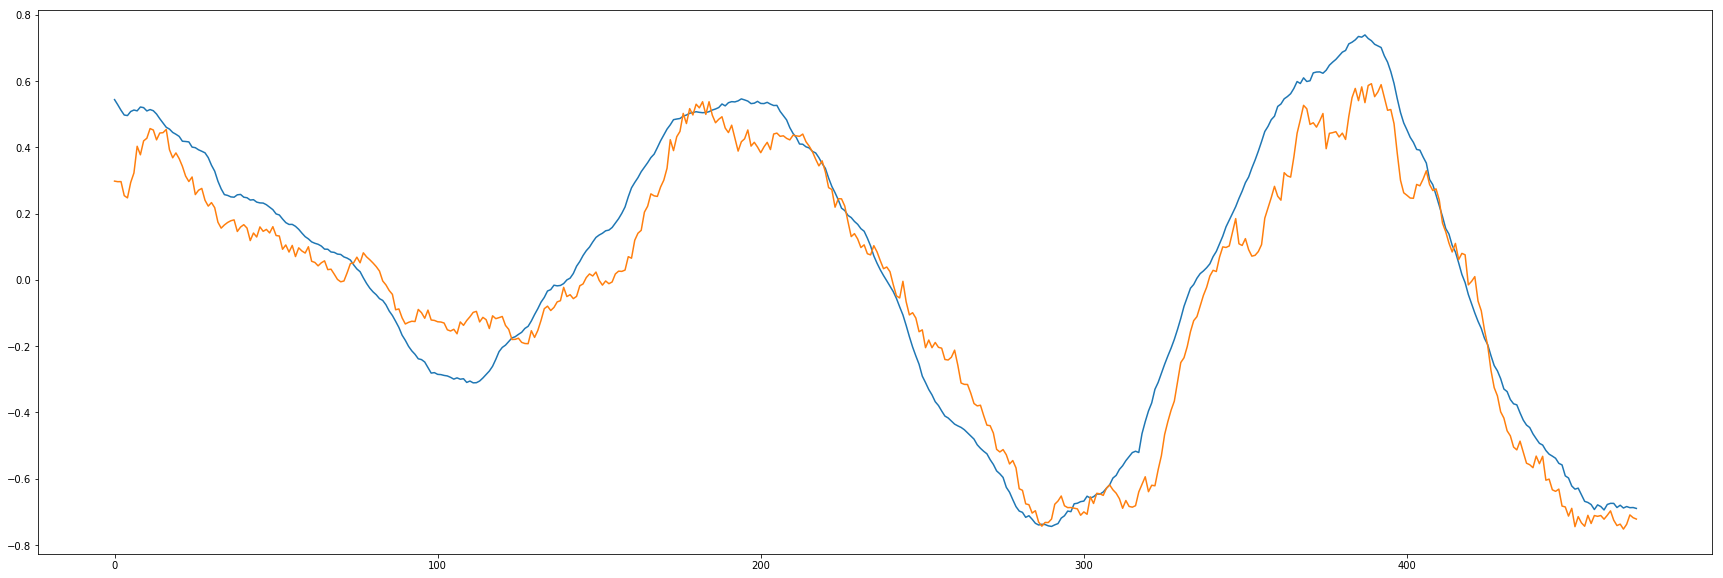

In [45]:
plt.figure(figsize=(30,10))
plt.plot(output1)

In [ ]:
exit()

In [ ]:
len(test_gen[0][0])

In [ ]:
test_gen[23][0][0][0][124][110]